In [1]:
import os
os.chdir('/raid/jimyeong/nohlab_diffusion')

In [2]:
import json
import numpy as np
import torch
from tqdm.auto import tqdm
from torchvision.utils import make_grid
import torchvision.transforms as T

from PIL import Image
from modeling import get_model, UNet
from diffusion.scheduler import BetaScheduler, get_scheduler
from diffusion.sampler import DDIMSampler, get_sampler

In [3]:
device = torch.device('cuda:2')
device

device(type='cuda', index=2)

In [4]:
ckpt_dir = 'outputs/rf_mnist_base'
ckpt_name = 'ckpt-200000'
use_ema = True

In [5]:

with open(os.path.join(ckpt_dir, 'train_args.json'), 'r') as f:
    train_args = json.load(f)
model_ckpt_path = os.path.join(ckpt_dir, 'ckpts', ckpt_name, 'ema_model.pt' if use_ema else 'model.pt')
model = get_model(train_args['model_type'], **train_args['model_cfg']).to(device)
ret = model.load_state_dict(torch.load(model_ckpt_path, map_location=device))
model.eval()
ret

<All keys matched successfully>

In [6]:
num_examples = 10
# z_shape = (3, 32, 32)
z_shape = (1, 28, 28)
seed = 1234
gen = torch.Generator(device=device).manual_seed(seed)
z = torch.randn(num_examples, *z_shape, generator=gen, device=device)
cond = torch.arange(num_examples, device=device) % 10
z.shape, cond.shape

(torch.Size([10, 1, 28, 28]), torch.Size([10]))

In [7]:
def get_eps_pred_func(model, cls=None, guidance_scale=1.0):
    def pred_fn(z, t):
        if guidance_scale == 1.0 and cls is not None:
            eps_pred = model(z, t, cls=cls)
        elif guidance_scale != 0 and cls is not None:
            z = torch.cat([z, z], dim=0)
            t = torch.cat([t, t], dim=0)
            cls_cond = torch.cat([cls, cls], dim=0)
            uncond_mask = torch.cat([torch.ones_like(cls), torch.zeros_like(cls)], dim=0)

            eps_pred = model(z, t, cls=cls_cond, uncond_mask=uncond_mask)
            eps_uncond, eps_cond = torch.chunk(eps_pred, 2, dim=0)
            eps_pred = eps_uncond + guidance_scale * (eps_cond - eps_uncond)
        else:
            eps_pred = model(z, t)
        return eps_pred
    return pred_fn

In [22]:
scheduler = get_scheduler(train_args['scheduler_type'], **train_args['scheduler_cfg'])
sampler_cfg = train_args['sampler_cfg']
sampler_cfg['n_steps'] = 100
sampler = get_sampler(train_args['sampler_type'], **train_args['sampler_cfg'])

  0%|          | 0/100 [00:00<?, ?it/s]

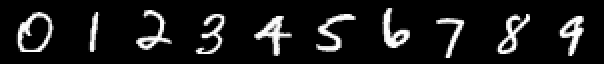

In [23]:
pred_fn = get_eps_pred_func(model, cls=cond, guidance_scale=1.0)
samples = sampler.sample(z, scheduler, pred_fn)
grid = make_grid(samples.cpu(), nrow=10, normalize=True, value_range=(-1, 1))
img = T.ToPILImage()(grid)
img.resize((img.width * 2, img.height * 2), resample=Image.NEAREST)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

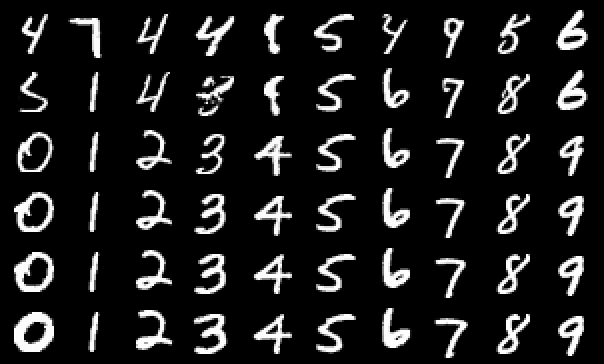

In [10]:
def make_guidance_scale_grid(scales=[0.0, 0.5, 1.0, 2.0, 3.0, 5.0]):
    ret = []
    for i, scale in enumerate(scales):
        pred_fn = get_eps_pred_func(model, cls=cond, guidance_scale=scale)
        samples = sampler.sample(z, scheduler, pred_fn)
        ret.append(samples.cpu())
    ret = torch.cat(ret, dim=0)
    grid = make_grid(ret, nrow=num_examples, normalize=True, value_range=(-1, 1))
    img = T.ToPILImage()(grid)
    img = img.resize((img.width * 2, img.height * 2), resample=Image.NEAREST)
    return img

make_guidance_scale_grid()